## Download Libraries

In [68]:
!pip install supervision
!pip install ultralytics
!pip install -q roboflow

In [2]:
import os
HOME = os.getcwd()
print(HOME)


/content


## Import Libraries

In [3]:
import supervision as sv
import ultralytics
from ultralytics import YOLO
from google.colab import drive
import numpy as np
import cv2
import PIL
import torch
from PIL import Image
import random
from torchvision.ops import box_convert
import torchvision.transforms.functional as TF
ultralytics.checks()

Ultralytics YOLOv8.0.218 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 27.1/166.8 GB disk)


## Mount Google Drive

In [4]:
drive.mount("/content/gdrive")

Mounted at /content/gdrive


## Initialize YOLO Model

In [5]:
from roboflow import Roboflow
rf = Roboflow(api_key="FQmBgtlhcDpO84Vn7Cuv")
project = rf.workspace().project("mouse-keypoint")
yoloKeypoint = project.version(3).model
localizerPath = '/content/gdrive/MyDrive/ConboyLabCode/objectLocalizer.pt'
mousePath = '/content/gdrive/MyDrive/ConboyLabCode/mouseBest.pt'
yoloLocalizer = YOLO(localizerPath)
yoloMouse = YOLO(mousePath)

loading Roboflow workspace...
loading Roboflow project...
WARNING ⚠️ /content/gdrive/MyDrive/ConboyLabCode/objectLocalizer.pt appears to require 'omegaconf', which is not in ultralytics requirements.
AutoInstall will run now for 'omegaconf' but this feature will be removed in the future.
Recommend fixes are to train a new model using the latest 'ultralytics' package or to run a command with an official YOLOv8 model, i.e. 'yolo predict model=yolov8n.pt'
requirements: Ultralytics requirement ['omegaconf'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144555 sha256=156bc034c8c6e1d452ab13b32c70b73a77d4445ca7ef3866772294480b73fc9e
  Store

## Initialize NOR Labeling Function

In [94]:
%matplotlib inline
import math
def noseFinder(centroids, centroidBox):
  for i in range(len(centroids)):
    if i + 1 <= len(centroids) - 1:
      if math.dist(centroids[i], centroidBox) > math.dist(centroids[i+1], centroidBox):
        nose = centroids[i]
        middle = centroids[i+1]
      else:
        nose = centroids[i+1]
        middle = centroids [i]
    else:
      nose = centroids[i]
      middle = centroidBox
  return nose, middle

def runPipeline(video, yoloMouse, yoloLocalizer, yoloKeypoint):
  cap = cv2.VideoCapture(video)
  bounding_box_annotator = sv.BoundingBoxAnnotator()
  if not cap.isOpened():
    print("Cannot parse Video")
    return
  while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    if not ret:
      break
    # Run Yolo to capture object locations
    results = yoloLocalizer(frame.copy(), verbose = False, conf = 0.4)[0]
    detectionsLocalizer = sv.Detections.from_ultralytics(results)
    annotated_frame = bounding_box_annotator.annotate(
     scene=frame.copy(),
     detections=detectionsLocalizer
    )
    heightBig, widthBig, _ = annotated_frame.shape
    if len(results.boxes) > 0:
      for i in range(len(results.boxes.xyxy)):
        coords = results.boxes.xyxy[i].cpu().numpy()
        x1, y1, x2, y2 = coords[0], coords[1], coords[2], coords[3]
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
    # Run Yolo to capture mouse locations
    results = yoloMouse(frame.copy(), verbose = False)[0]
    detectionsMouse = sv.Detections.from_ultralytics(results)
    annotated_frame = bounding_box_annotator.annotate(
     scene=annotated_frame,
     detections=detectionsMouse
    )
    if len(results.boxes) > 0:
      MouseList = []
      for i in range(len(results.boxes.xyxy)):
        coords = results.boxes.xyxy[i].cpu().numpy()
        x1, y1, x2, y2 = coords[0], coords[1], coords[2], coords[3]
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        centroidBox = (int((x1+x2)//2),int((y1+y2)//2))
        imagePIL = Image.fromarray(frame)
        imagecrop = imagePIL.crop((x1, y1, x2, y2))
        # Run YOLO to capture Keypoints:
        resultsKeypoint = yoloKeypoint.predict(np.array(imagecrop), confidence=40, overlap=30).json()
        detectionsKey = sv.Detections.from_roboflow(resultsKeypoint)
        centroids = []
        mouse_frame = np.array(imagecrop)
        for i in range(len(detectionsKey.xyxy)):
          coords = detectionsKey.xyxy[i]
          x1Crop, y1Crop, x2Crop, y2Crop = coords[0], coords[1], coords[2], coords[3]
          centroid = (int((x1Crop+x2Crop)//2+x1),int((y1Crop+y2Crop)//2+y1))
          annotated_frame = cv2.circle(annotated_frame, centroid, radius=0, color=(255, 0, 0), thickness=5)
          centroids.append(centroid)
        if len(centroids) != 2:
          annotated_frame = cv2.circle(annotated_frame, centroidBox, radius=0, color=(0, 255, 0), thickness=5)
          centroids.append(centroidBox)
        nose, middle = noseFinder(centroids, centroidBox)
        # TO DO Iterate Through Each Box On The Mouse's Side, map it to the mouse, then calculate the distance between the mouses nose and the object center, and 4 corners, draw vector line between two pose points of mouse
        # Then append all calculations to MouseDict
        MouseDict = dict(nose=nose, middle=middle)
        MouseList.append(MouseDict)
    sv.plot_image(annotated_frame, (16, 16))




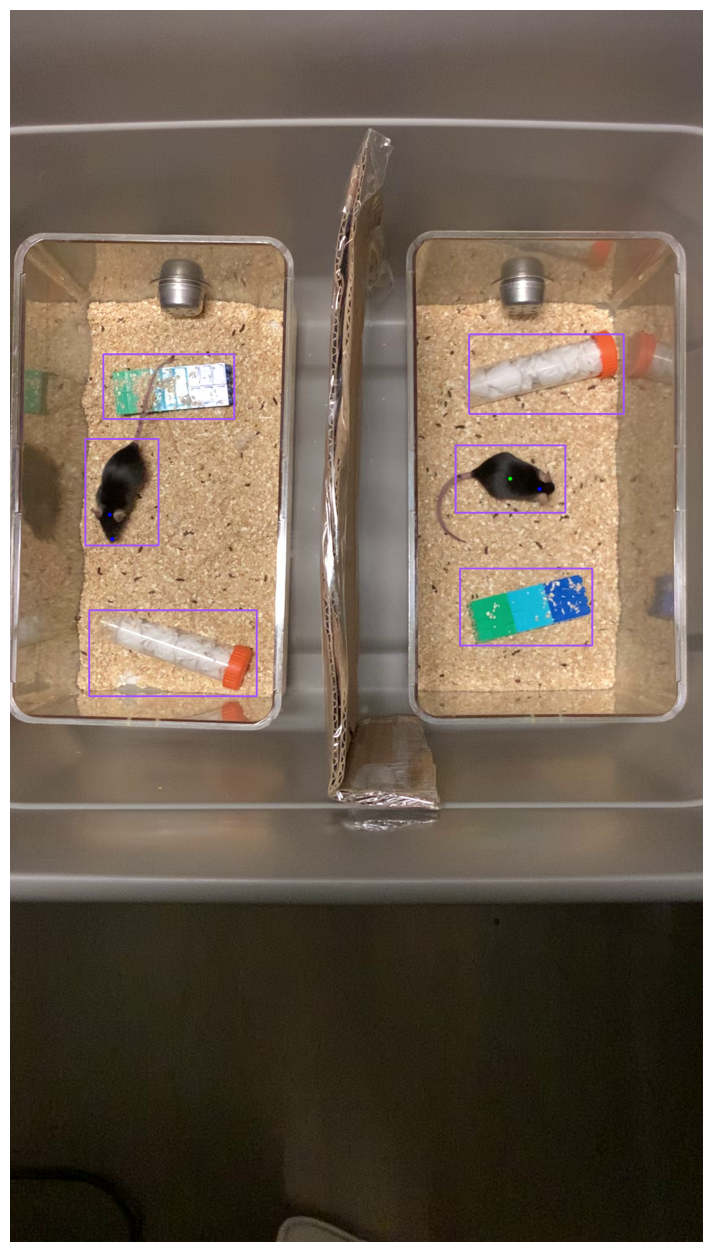

KeyboardInterrupt: ignored

In [95]:
videoPath = '/content/gdrive/MyDrive/ConboyLabCode/OutputVid/segment_48.MOV'
runPipeline(videoPath,yoloMouse, yoloLocalizer, yoloKeypoint)